# Define N Dim Room Dateset

In [ ]:
import torch as th
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

class NDimRoomDataset(Dataset):
    """
    PyTorch Dataset for n-dimensional room exploration data.
    Generates synthetic data where temperature readings are drawn from N(1, 0.5)
    when sum of coordinates >= n/2, and 0 otherwise.
    """
    def __init__(self, n_samples: int, n_dim: int = 2, split: str = "train",
                 train_ratio: float = 0.8, random_seed: int = None):
        """
        Initialize the dataset.

        Args:
            n_samples (int): Total number of samples to generate
            n_dim (int): Number of dimensions for the room
            split (str): Either "train" or "test"
            train_ratio (float): Ratio of data to use for training
            random_seed (int, optional): Random seed for reproducibility
        """
        super().__init__()

        if random_seed is not None:
            np.random.seed(random_seed)
            th.manual_seed(random_seed)

        # Generate all data
        total_samples = int(n_samples / train_ratio if split == "train" else n_samples / (1 - train_ratio))
        X = np.random.uniform(0, 1, size=(total_samples, n_dim))
        coord_sums = np.sum(X, axis=1)

        # Initialize kappa array
        kappa = np.zeros(total_samples)
        random_temp_mask = coord_sums >= n_dim/2
        kappa[random_temp_mask] = np.random.normal(1, 0.5, size=np.sum(random_temp_mask))

        # Split data
        split_idx = int(total_samples * train_ratio)
        if split == "train":
            self.X = X[:split_idx]
            self.kappa = kappa[:split_idx]
        else:
            self.X = X[split_idx:]
            self.kappa = kappa[split_idx:]

        # Convert to torch tensors
        self.X = th.FloatTensor(self.X)
        self.kappa = th.FloatTensor(self.kappa)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.kappa[idx]

    @property
    def input_dim(self):
        return self.X.shape[1]

# Initialize example dataset
dataset = NDimRoomDataset(10000, n_dim=2, split="train", random_seed=42)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# print first 10 data
for i, (x, y) in enumerate(dataloader):
    print(x[:10], y[:10])
    if i == 1:
        break

tensor([[0.2793, 0.6429],
        [0.8854, 0.0665],
        [0.4362, 0.6583],
        [0.0363, 0.9840],
        [0.7682, 0.8030],
        [0.6332, 0.7211],
        [0.9384, 0.1137],
        [0.9326, 0.4784],
        [0.4678, 0.3114],
        [0.5765, 0.9339]]) tensor([0.0000, 0.0000, 0.8704, 0.6512, 1.3688, 0.7786, 0.9443, 1.2527, 0.0000,
        1.1570])
tensor([[0.0443, 0.3206],
        [0.7982, 0.4331],
        [0.8047, 0.7365],
        [0.0139, 0.6494],
        [0.1685, 0.0304],
        [0.4680, 0.2134],
        [0.0991, 0.6230],
        [0.9132, 0.2320],
        [0.8701, 0.5789],
        [0.5342, 0.6789]]) tensor([0.0000, 2.4668, 0.2264, 0.0000, 0.0000, 0.0000, 0.0000, 1.5693, 1.0003,
        0.4966])


# Define Model

In [ ]:
class CDRMNet(nn.Module):
    def __init__(self, hidden_dims=[64, 128, 128, 128, 64]):
        super().__init__()

        layers = []
        input_dim = 3

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.SiLU(),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(0.2)
            ])
            input_dim = hidden_dim

        # Add residual connections
        self.residual_layers = nn.ModuleList([
            nn.Linear(hidden_dims[i], hidden_dims[i+1])
            for i in range(len(hidden_dims)-1)
        ])

        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x, y, clip_min=1e-6, clip_max=1-1e-6):
        inputs = th.cat([x, y], dim=-1)
        raw_output = self.net(inputs)
        return th.clamp(th.sigmoid(raw_output), clip_min, clip_max)

class CDRM:
    def __init__(self, model, device, langevin_steps=10, langevin_step_size=0.1,
                 noise_scale=0.01, num_neg_samples=32,
                 inference_samples=100, inference_step_size=0.01):
        self.model = model.to(device)
        self.device = device
        # Training parameters
        self.langevin_steps = langevin_steps
        self.langevin_step_size = langevin_step_size
        self.noise_scale = noise_scale
        self.num_neg_samples = num_neg_samples
        # Inference parameters
        self.inference_samples = inference_samples
        self.inference_step_size = inference_step_size
        self.optimizer = self.optimizer = th.optim.AdamW(model.parameters(),
                               lr=1e-3,
                               weight_decay=1e-4,
                               amsgrad=True)

        self.scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
                                self.optimizer, mode='min', factor=0.5, patience=10
                                )

    def langevin_sampling(self, batch_size):
        """Generate negative samples using Langevin dynamics"""
        # Initialize random samples
        x_neg = th.rand(batch_size * self.num_neg_samples, 2, device=self.device) * 1.2247
        y_neg = th.rand(batch_size * self.num_neg_samples, 1, device=self.device) * 2

        # Perform Langevin dynamics
        for step in range(self.langevin_steps):
            x_neg.requires_grad_(True)
            y_neg.requires_grad_(True)

            # Get density
            density = self.model(x_neg, y_neg)

            # Compute gradients
            grad_x, grad_y = th.autograd.grad(density.sum(), [x_neg, y_neg])

            # Update samples using gradients and add noise
            x_noise = th.randn_like(x_neg) * self.noise_scale
            y_noise = th.randn_like(y_neg) * self.noise_scale

            with th.no_grad():
                x_neg = x_neg + self.langevin_step_size * grad_x + x_noise
                y_neg = y_neg + self.langevin_step_size * grad_y + y_noise

                # Clip to valid range
                x_neg.clamp_(0, 1)
                y_neg.clamp_(0, 2)

        return x_neg.detach(), y_neg.detach()

    def train_step(self, x, y):
        self.model.train()
        self.optimizer.zero_grad()

        batch_size = x.size(0)

        # Generate positive samples (actual data points)
        pos_density = self.model(x, y)

        # Generate negative samples using Langevin dynamics
        x_neg, y_neg = self.langevin_sampling(batch_size)
        neg_density = self.model(x_neg, y_neg)

        # Contrastive loss
        pos_loss = -th.log(pos_density + 1e-6).mean()
        neg_loss = -th.log(1 - neg_density + 1e-6).mean()

        loss = pos_loss + neg_loss

        loss.backward()
        th.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item(), pos_density.mean().item(), neg_density.mean().item()

In [ ]:
# Setup
device = "cuda" if th.cuda.is_available() else "cpu"
n_dim = 2  # Can be any dimension

# Create dataset
dataset = NDimRoomDataset(30000, n_dim=n_dim, split="train", random_seed=42)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model
model = CDRMNet()
density_estimator = CDRM(model, device)

# Training with progress tracking
num_epochs = 150
density_stats = []

with tqdm(range(num_epochs), desc="Training") as pbar:
    for epoch in pbar:
        epoch_loss = 0
        epoch_pos_density = 0
        epoch_neg_density = 0
        num_batches = 0

        for x, y in dataloader:
            # print(x)
            # print(y)

            # reshape y
            y = y.view(-1, 1)

            x = x.to(device)
            y = y.to(device)

            # print(x)
            # print(y)

            # print(th.cat([x, y], dim=-1))

            loss, pos_density, neg_density = density_estimator.train_step(x, y)

            epoch_loss += loss
            epoch_pos_density += pos_density
            epoch_neg_density += neg_density
            num_batches += 1

        # save model for every 50 epoch
        if epoch % 50 == 0:
            save_cdrm_model(density_estimator, f"model_epoch_{epoch}.pth")

        avg_loss = epoch_loss / num_batches
        avg_pos_density = epoch_pos_density / num_batches
        avg_neg_density = epoch_neg_density / num_batches

        density_stats.append({
            'pos': avg_pos_density,
            'neg': avg_neg_density
        })

        pbar.set_postfix(
            loss=f"{avg_loss:.4f}",
            pos_density=f"{avg_pos_density:.4f}",
            neg_density=f"{avg_neg_density:.4f}"
        )

Training:   0%|          | 0/150 [00:00<?, ?it/s]

Model saved to model_epoch_0.pth
Model saved to model_epoch_50.pth
Model saved to model_epoch_100.pth


# Verify model output


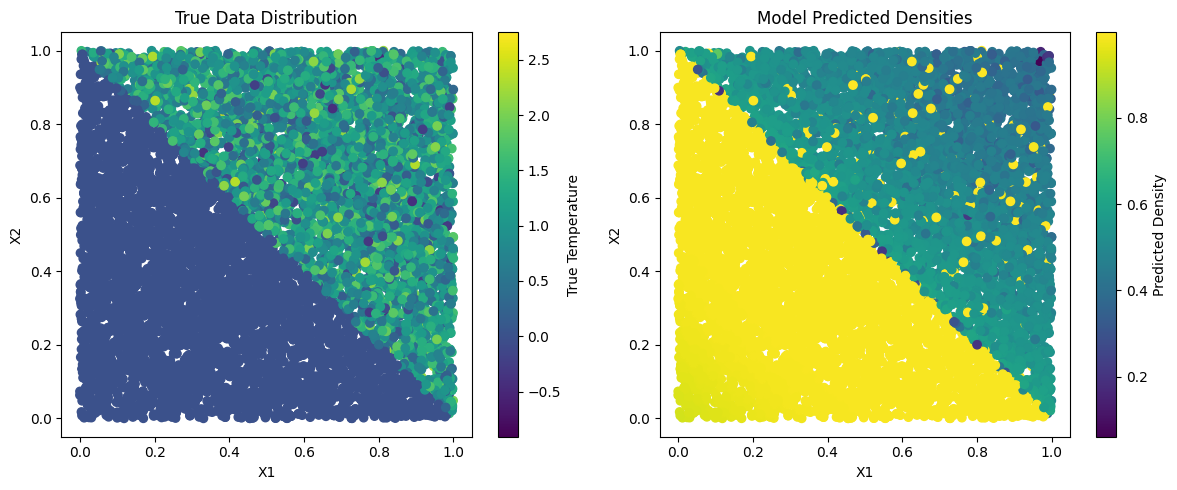


Density Statistics:
Mean density: 0.7521
Std density: 0.2460
Min density: 0.0610
Max density: 0.9981

Correlation between true temperatures and predicted densities: -0.8006


In [ ]:
def evaluate_model(model, dataset, num_samples=10000, device="cuda" if th.cuda.is_available() else "cpu"):
    """
    Evaluate the trained model by sampling points and comparing predicted densities.

    Args:
        model: Trained CDRM model
        dataset: NDimRoomDataset instance
        num_samples: Number of points to sample
        device: Device to run evaluation on
    """
    model.model.eval()

    # Sample random points from the dataset
    indices = np.random.choice(len(dataset), num_samples)
    X_eval = []
    y_eval = []
    densities = []

    with th.no_grad():
        for idx in indices:
            x, y = dataset[idx]
            x = x.to(device)
            y = y.view(-1, 1).to(device)

            # print(x.unsqueeze(0))
            # print(y)

            density = model.model(x.unsqueeze(0), y)

            X_eval.append(x.cpu().numpy())
            y_eval.append(y.cpu().numpy())
            densities.append(density.cpu().numpy())

    X_eval = np.array(X_eval)
    y_eval = np.array(y_eval)
    densities = np.array(densities).flatten()

    # Create scatter plot
    plt.figure(figsize=(12, 5))

    # Plot 1: Original data distribution
    plt.subplot(121)
    scatter = plt.scatter(X_eval[:, 0], X_eval[:, 1], c=y_eval, cmap='viridis')
    plt.colorbar(scatter, label='True Temperature')
    plt.title('True Data Distribution')
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot 2: Model predicted densities
    plt.subplot(122)
    scatter = plt.scatter(X_eval[:, 0], X_eval[:, 1], c=densities, cmap='viridis')
    plt.colorbar(scatter, label='Predicted Density')
    plt.title('Model Predicted Densities')
    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("\nDensity Statistics:")
    print(f"Mean density: {densities.mean():.4f}")
    print(f"Std density: {densities.std():.4f}")
    print(f"Min density: {densities.min():.4f}")
    print(f"Max density: {densities.max():.4f}")

    # Analyze correlation between true temperatures and predicted densities
    correlation = np.corrcoef(y_eval.flatten(), densities)[0, 1]
    print(f"\nCorrelation between true temperatures and predicted densities: {correlation:.4f}")

    return X_eval, y_eval, densities

X_eval, y_eval, densities = evaluate_model(density_estimator, dataset)

In [ ]:
def langevin_dynamics_step(model, y_samples, x_current, step_size=0.01, noise_std=0.01):
    """
    Perform one step of Langevin dynamics sampling.
    Note: model expects inputs in (y, x) order even though x is the condition
    """
    # y_samples = y_samples.detach().clone().requires_grad_(True)
    y_samples = y_samples.to(device).clone().requires_grad_(True)

    # Note the order: (y_samples, x_expanded) instead of (x_expanded, y_samples)
    x_expanded = x_current.expand(y_samples.size(0), -1)
    # print("x current: ", x_current)
    # # print("x expanded: ", x_expanded)

    # print(y_samples)
    # print(x_expanded)
    # density = model(y_samples, x_expanded)
    density = model(x_expanded, y_samples)

    log_density = th.log(density + 1e-6)
    grad = th.autograd.grad(log_density.sum(), y_samples, create_graph=False)[0]

    with th.no_grad():
        noise = th.randn_like(y_samples) * noise_std
        y_samples = y_samples + step_size * grad + noise

    return y_samples, density

def estimate_input_density(training_set, device="cuda" if th.cuda.is_available() else "cpu", bandwidth=0.1):
    """
    Precompute input space density estimation using the training set
    """
    # Get all training inputs
    all_x = []
    for i in range(0, len(training_set), 100):
        batch = training_set[i:i+100]
        x_train, _ = batch
        all_x.append(x_train)
    all_x = th.cat(all_x, dim=0).to(device)

    # Compute pairwise distances for all training points
    def compute_kde(x):
        # Compute KDE for a single point
        distances = th.sum((all_x - x.unsqueeze(0))**2, dim=1)
        kde = th.mean(th.exp(-distances / (2 * bandwidth**2)))
        return kde

    # Get density distribution statistics
    densities = []
    print("Computing training set density distribution...")
    for i in tqdm(range(len(all_x))):
        kde = compute_kde(all_x[i])
        densities.append(kde)

    densities = th.stack(densities)
    density_mean = densities.mean()
    density_std = densities.std()

    return compute_kde, density_mean, density_std

def predict(model, x, compute_kde=None, density_stats=None, y_range=(0.0, 1.44),
           num_samples=100, num_steps=50, alpha=0.5, step_size=0.01,
           noise_std=0.01, device="cpu"):
    """
    Enhanced prediction using precomputed input space density estimation
    """
    model.train()
    batch_size = x.size(0)

    predictions = th.zeros(batch_size, device=device)
    epistemic = th.zeros(batch_size, device=device)
    aleatoric = th.zeros(batch_size, device=device)

    density_mean, density_std = density_stats if density_stats else (0, 1)

    for i in range(batch_size):
        min_val, max_val = y_range
        y_samples = th.rand(num_samples, 1, device=device) * (max_val - min_val) + min_val
        x_current = x[i:i+1]

        # Compute input density if KDE is provided
        if compute_kde is not None:
            input_density = compute_kde(x_current.squeeze())
            normalized_density = (input_density - density_mean) / density_std
            base_epistemic = 1 / (1 + th.exp(normalized_density))  # sigmoid scaling
        else:
            base_epistemic = 0.5

        valid_samples_set = th.zeros(0, device=device)
        step_densities = []

        for _ in range(num_steps):
            y_samples, density = langevin_dynamics_step(
                model,
                y_samples,
                x_current,
                step_size=step_size,
                noise_std=noise_std
            )
            y_samples = th.clamp(y_samples, min_val, max_val)
            step_densities.append(density)

            valid_mask = density > alpha
            if valid_samples_set.size(0) == 0:
                valid_samples_set = y_samples[valid_mask]
            else:
                valid_samples_set = th.cat((valid_samples_set, y_samples[valid_mask]), dim=0)

        with th.no_grad():
            num_valid_samples = valid_samples_set.size(0)
            if num_valid_samples > 0:
                x_expanded = x_current.expand(num_valid_samples, -1)
                y_samples = valid_samples_set.view(-1, 1)
                valid_densities = model(x_expanded, y_samples).squeeze()

                predictions[i] = valid_samples_set[valid_densities.argmax()]

                # Combine input space density with sample statistics
                step_densities = th.cat(step_densities)
                density_var = step_densities.std() / step_densities.mean()

                epistemic[i] = (base_epistemic + (1 - valid_densities.max()) * density_var) / 2

                if valid_samples_set.size(0) > 1:
                    centered = valid_samples_set - predictions[i]
                    variance = (centered**2 * (1 / valid_samples_set.size(0))).sum()
                    aleatoric[i] = th.sqrt(variance)
                else:
                    aleatoric[i] = 0.0
            else:
                predictions[i] = 0.0
                epistemic[i] = 1.0
                aleatoric[i] = 0.0

    model.eval()
    return predictions, epistemic, aleatoric

In [ ]:
# draw an x from dataset
x = dataset[0][0]
y = dataset[0][1]
x = x.to(device)
x = x.unsqueeze(0)
print("Input x :", x)
print("Truth y :", y)
print(predict(density_estimator.model, x))

Input x : tensor([[0.3745, 0.9507]], device='cuda:0')
Truth y : tensor(1.9338)
(tensor([0.7971]), tensor([0.2602]), tensor([0.2718]))


In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm.auto import tqdm

def test_au_eu_classification(model, n_dim=3, n_samples=1000, compute_kde=None,
                            density_stats=None, device="cuda" if th.cuda.is_available() else "cpu"):
    """
    Test the model's ability to classify AU and EU using a single set of samples.
    Samples points from [0, √1.5] to get balanced proportions of:
    - No uncertainty (inside unit cube, sum <= n/2)
    - Only AU (inside unit cube, sum > n/2)
    - EU (outside unit cube)

    Args:
        model: The trained CDRM model
        n_dim: Number of dimensions for input space
        n_samples: Number of test samples
        device: Device to run the test on

    Returns:
        dict: Dictionary containing AUPRC and AUROC scores for both AU and EU
    """
    # Generate single set of test data
    # set torch random seed
    th.manual_seed(42)

    # Sample from [0, √1.5] to get balanced areas
    x = th.rand(n_samples, n_dim, device=device) * (1.5 ** (1/n_dim))  # √1.5 ≈ 1.2247

    # Calculate true AU and EU
    coord_sums = x.sum(dim=1)
    is_inside_unit = (x <= 1.0).all(dim=1)

    # True AU exists if sum of entries > n/2 AND point is inside unit cube
    true_au = (coord_sums > n_dim/2).float() * is_inside_unit.float()

    # True EU exists if ANY coordinate > 1.0
    true_eu = (~is_inside_unit).float()

    # Print distribution statistics
    n_no_uncertainty = ((coord_sums <= n_dim/2) & is_inside_unit).sum().item()
    n_only_au = ((coord_sums > n_dim/2) & is_inside_unit).sum().item()
    n_eu = (~is_inside_unit).sum().item()

    print("\nSample Distribution:")
    print(f"No Uncertainty: {n_no_uncertainty/n_samples:.3f}")
    print(f"Only AU: {n_only_au/n_samples:.3f}")
    print(f"EU: {n_eu/n_samples:.3f}")

    # Get predictions with progress bar
    pred_eu = []
    pred_au = []
    print("\nProcessing predictions...")
    for i in tqdm(range(0, n_samples, 100), desc="Progress"):
        batch_x = x[i:i+100]
        _, batch_eu, batch_au = predict(model, batch_x, compute_kde=compute_kde,
                                      density_stats=density_stats, alpha=0.4)
        pred_eu.append(batch_eu)
        pred_au.append(batch_au)

    predicted_eu = th.cat(pred_eu)
    predicted_au = th.cat(pred_au)

    # Convert to numpy for sklearn metrics
    true_au_np = true_au.cpu().numpy()
    pred_au_np = predicted_au.cpu().numpy()
    true_eu_np = true_eu.cpu().numpy()
    pred_eu_np = predicted_eu.cpu().numpy()

    print("\nSample predictions (first 20):")
    print("True AU:", true_au_np[:20])
    print("Pred AU:", pred_au_np[:20])
    print("True EU:", true_eu_np[:20])
    print("Pred EU:", pred_eu_np[:20])

    results = {
        'AU_AUPRC': average_precision_score(true_au_np, pred_au_np),
        'AU_AUROC': roc_auc_score(true_au_np, pred_au_np),
        'EU_AUPRC': average_precision_score(true_eu_np, pred_eu_np),
        'EU_AUROC': roc_auc_score(true_eu_np, pred_eu_np)
    }

    return results

# Example usage remains the same:
def run_test(density_estimator, n_dim=3, n_samples=1000):
    """
    Run the test and print results
    """
    model = density_estimator.model
    model.eval()

    # Compute density estimation from training set
    print("Computing input space density estimation...")
    compute_kde, density_mean, density_std = estimate_input_density(dataset)
    density_stats = (density_mean, density_std)

    print(f"\nStarting evaluation with {n_samples} samples in {n_dim} dimensions...")
    results = test_au_eu_classification(
        model,
        n_dim=n_dim,
        n_samples=n_samples,
        compute_kde=compute_kde,
        density_stats=density_stats
    )

    print("\nTest Results:")
    print(f"Aleatoric Uncertainty:")
    print(f"  AUPRC: {results['AU_AUPRC']:.4f}")
    print(f"  AUROC: {results['AU_AUROC']:.4f}")
    print(f"Epistemic Uncertainty:")
    print(f"  AUPRC: {results['EU_AUPRC']:.4f}")
    print(f"  AUROC: {results['EU_AUROC']:.4f}")

    return results

results = run_test(density_estimator, n_dim=2, n_samples=1000)

# First, precompute the density estimation
# compute_kde, density_mean, density_std = estimate_input_density(dataset)
# density_stats = (density_mean, density_std)

# # Then use it in testing
# results = test_au_eu_classification(
#     model,
#     compute_kde=compute_kde,
#     density_stats=density_stats,
#     n_dim=2,
#     n_samples=1000
# )

Computing input space density estimation...
Computing training set density distribution...


  0%|          | 0/30000 [00:00<?, ?it/s]


Starting evaluation with 1000 samples in 2 dimensions...

Sample Distribution:
No Uncertainty: 0.329
Only AU: 0.337
EU: 0.334

Processing predictions...


Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Sample predictions (first 20):
True AU: [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
Pred AU: [0.00443071 0.00287023 0.00637316 0.80092674 0.08198363 0.60995924
 0.8853337  0.00546596 0.8476388  0.00573826 0.8214044  0.43064553
 0.00598215 0.00610921 0.3578527  0.00259321 0.83862203 0.4890649
 0.0053034  0.7941983 ]
True EU: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
Pred EU: [0.43060157 0.3780188  0.16347595 0.27456307 0.15622242 0.5056645
 0.4805511  0.27928257 0.37195393 0.1651614  0.49289688 0.5049943
 0.15135644 0.3331349  0.5061023  0.35715252 0.17520034 0.49084413
 0.16423213 0.42021883]

Test Results:
Aleatoric Uncertainty:
  AUPRC: 0.7170
  AUROC: 0.8876
Epistemic Uncertainty:
  AUPRC: 0.9961
  AUROC: 0.9981


# Save the trained model

In [ ]:
def save_cdrm_model(cdrm, filepath):
    """
    Save the CDRM model and its configuration

    Args:
        cdrm: CDRM instance
        filepath: Path where the model should be saved
    """
    save_dict = {
        'model_state_dict': cdrm.model.state_dict(),
        'optimizer_state_dict': cdrm.optimizer.state_dict(),
        'config': {
            'langevin_steps': cdrm.langevin_steps,
            'langevin_step_size': cdrm.langevin_step_size,
            'noise_scale': cdrm.noise_scale,
            'num_neg_samples': cdrm.num_neg_samples,
            'inference_samples': cdrm.inference_samples,
            'inference_step_size': cdrm.inference_step_size
        }
    }
    th.save(save_dict, filepath)
    print(f"Model saved to {filepath}")

def load_cdrm_model(filepath, device="cuda" if th.cuda.is_available() else "cpu"):
    """
    Load a saved CDRM model

    Args:
        filepath: Path to the saved model
        device: Device to load the model to

    Returns:
        CDRM: Loaded CDRM instance
    """
    # Load the saved dictionary
    checkpoint = th.load(filepath, map_location=device)

    # Create a new model with the same architecture
    model = CDRMNet()

    # Create a new CDRM instance with the saved configuration
    cdrm = CDRM(
        model=model,
        device=device,
        langevin_steps=checkpoint['config']['langevin_steps'],
        langevin_step_size=checkpoint['config']['langevin_step_size'],
        noise_scale=checkpoint['config']['noise_scale'],
        num_neg_samples=checkpoint['config']['num_neg_samples'],
        inference_samples=checkpoint['config']['inference_samples'],
        inference_step_size=checkpoint['config']['inference_step_size']
    )

    # Load the model and optimizer states
    cdrm.model.load_state_dict(checkpoint['model_state_dict'])
    cdrm.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"Model loaded from {filepath}")
    return cdrm

# To save your trained model:
# save_cdrm_model(density_estimator, "cdrm_model_2droom.pth")

# To load the saved model later:
# density_estimator = load_cdrm_model("cdrm_model_2droom.pth")